In [2]:
import pandas as pd
from utils import *
df = pd.read_csv('predictive_maintenance.csv')

由于这是时间序列数据，首先想到构建RNN模型进行预测
首先由于FP点很少，针对每个设备绘制折线图，查看每个设备失败的原因

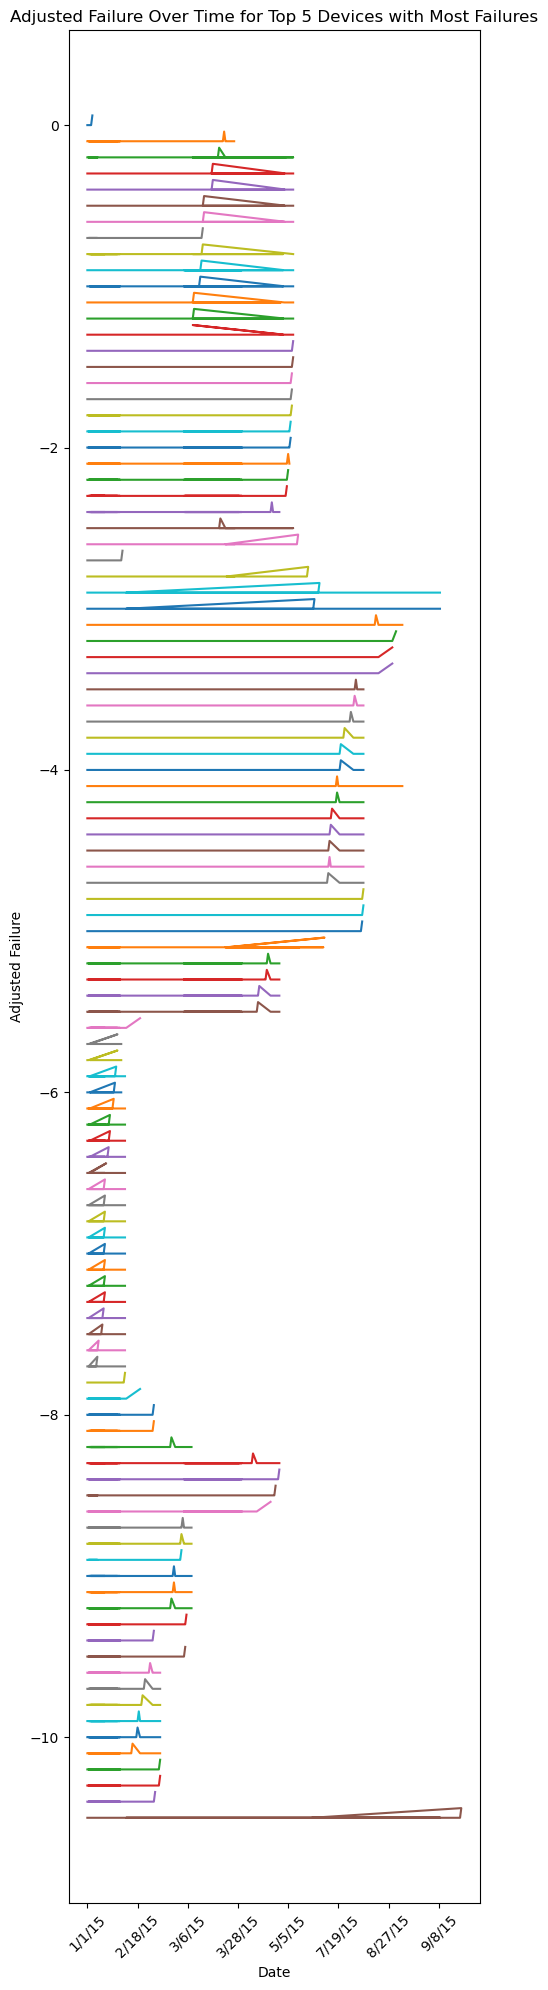

In [51]:
import pandas as pd
import matplotlib.pyplot as plt


df_failure = df[df['failure'] == 1]
devices = df_failure['device'].value_counts().index.tolist()


df_top = df[df['device'].isin(devices)]
df_top = df_top.replace(1,0.06)
plt.figure(figsize=(5, 20))
offset = 0.0  # 初始偏移量
for device in devices:
    df_device = df_top[df_top['device'] == device].sort_values('date')
    plt.plot(df_device['date'], df_device['failure'] - offset, linestyle='-')
    offset += 0.1

# 设置X轴的日期标签数量和格式
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # 只显示10个日期标签
plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel('Adjusted Failure')
plt.title('Adjusted Failure Over Time for Top 5 Devices with Most Failures')
plt.tight_layout()
plt.show()

In [52]:
# 检查是否有设备failure了两次
failed_devices = df[df['failure'] == 1]['device'].value_counts()
failed_devices = failed_devices[failed_devices > 1].index.tolist()
failed_devices

[]

In [46]:
# 筛选从来没有失败的设备和有失败的设备的信息
device_counts = df['device'].value_counts()

# Devices with failures
devices_with_failures = df[df['failure'] == 1]['device'].unique()
devices_with_failures_count = df[df['device'].isin(devices_with_failures)]['device'].value_counts()
avg_devices_with_failures = devices_with_failures_count.mean()

# Devices without failures
devices_without_failures = device_counts.index.difference(devices_with_failures)
devices_without_failures_count = df[df['device'].isin(devices_without_failures)]['device'].value_counts()
avg_devices_without_failures = devices_without_failures_count.mean()

result_without_failures = pd.DataFrame({
    'Device': devices_without_failures_count.index.tolist() + ['Average'],
    'Count': devices_without_failures_count.values.tolist() + [avg_devices_without_failures]
})

# Append average for devices with failures
result_with_failures = pd.DataFrame({
    'Device': devices_with_failures_count.index.tolist() + ['Average'],
    'Count': devices_with_failures_count.values.tolist() + [avg_devices_with_failures]
})
display(result_with_failures)
result_without_failures

,Device,Count
0,W1F0T0B1,299.000000
1,Z1F14BGY,282.000000
2,S1F0JGJV,278.000000
3,Z1F0MRPJ,230.000000
4,W1F11ZG9,229.000000
...,...,...
102,S1F11MB0,7.000000
103,S1F10E6M,7.000000
104,S1F0CTDN,7.000000
105,S1F0RRB1,5.000000


,Device,Count
0,Z1F0QLC1,304.000000
1,Z1F0KJDS,304.000000
2,Z1F0MA1S,304.000000
3,S1F0E9EP,304.000000
4,S1F0EGMT,304.000000
...,...,...
1059,Z1F0LKBP,5.000000
1060,S1F04KSC,4.000000
1061,W1F0WJFT,3.000000
1062,W1F1DA5ÿ,1.000000


分别查看有损坏情况的设备和没损坏情况的设备的数据量情况，发现平均数集中在100左右。
#### RNN模型架构(LSTM, GRU)
* 模型构想
首先我设想构建N个cell，每一个cell存储一种设备、在时间序列上的点的9个特征信息
由于失败的数量过少，所以在构造数据时默认认为这N个时间戳下设备都没有损坏。

* 输入数据
经过观察发现有损坏的设备的数据特征如下：大多数数据在损坏后就没什么数据了，所以我想只用损坏那天前的所有数据来训练。
因为是二分类问题，所以输入的数据分为两类：
**第一类**是在第N天设备损坏的情况，最后的输出为1；；**第二类**是在第N天设备没有损坏的情况，最后输出为0

* 输入不平衡的问题
由于存在损坏的设备：没有存在损坏的设备的比为1：10 (107:1064)
所以需要一个方法来平衡数据集，我的几个思路
1. 数据增强：对于每个损坏设备构造多个样本
对于第一类设备，可以取损坏当天和前后3天的数据都作为最终输出。且为了过采样，可以从前M天中抽取N天作为样本，这样对于每个设备就能构造出很
2. SMOTE
对于从来没有损坏的设备，如果强行构造损坏的数据点感觉不符合事实
对于有损坏的设备，在状态正常的时间线上构造损坏的数据点感觉也不符合事实
3. 权重调整：给予少数类更高的权重，从而在损失函数中增加对这些样本的惩罚。
4. ...


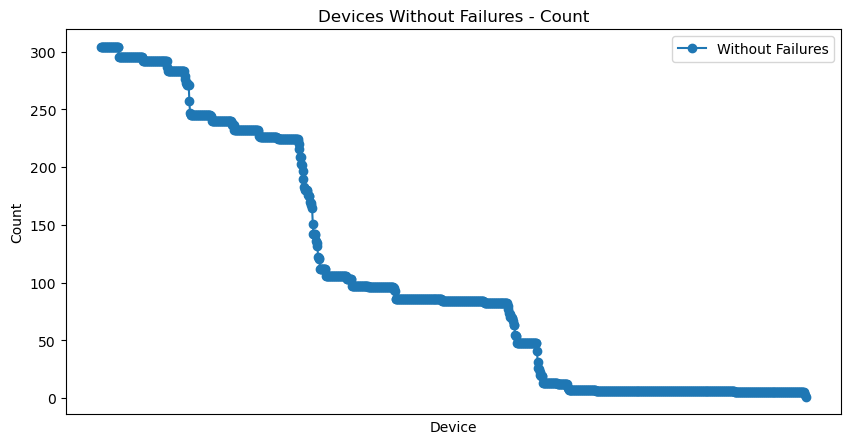

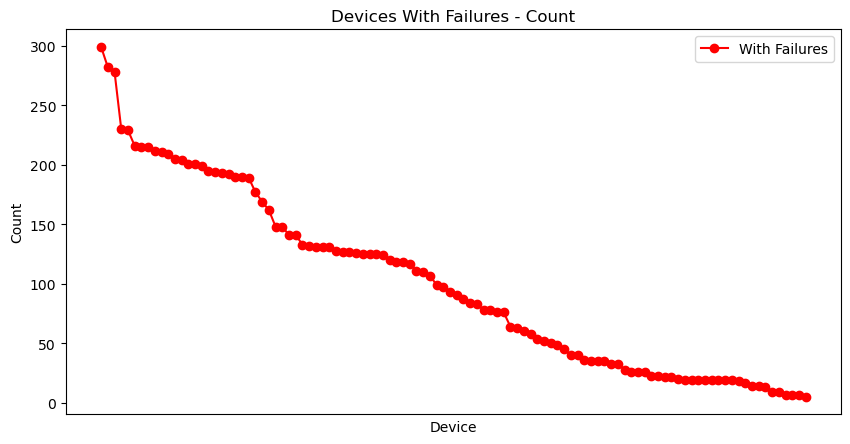

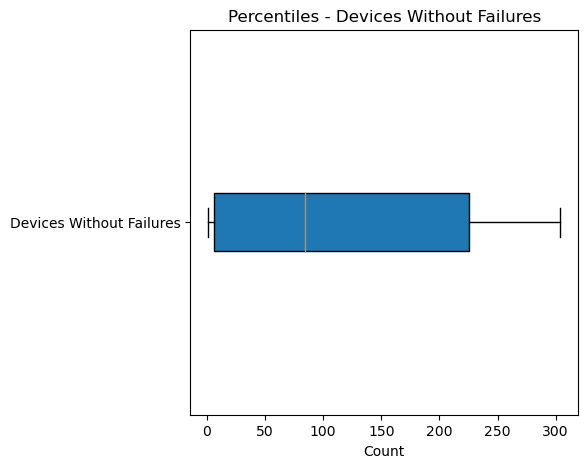

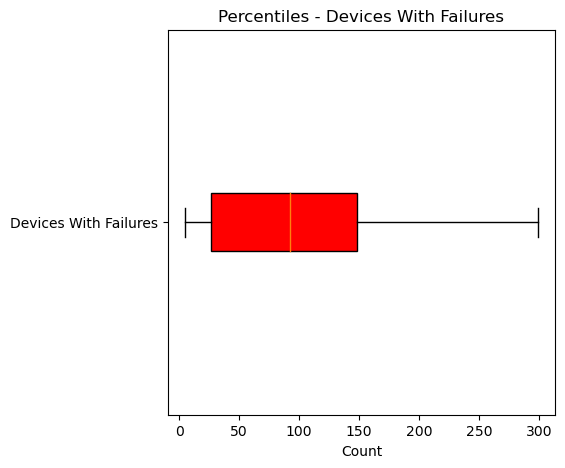

In [53]:
import numpy as np
plt.figure(figsize=(10, 5))
plt.plot(result_without_failures['Device'][:-1], result_without_failures['Count'][:-1], marker='o', label='Without Failures')
plt.title('Devices Without Failures - Count')
plt.xlabel('Device')
plt.xticks([])
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Devices with failures
plt.figure(figsize=(10, 5))
plt.plot(result_with_failures['Device'][:-1], result_with_failures['Count'][:-1], marker='o', color='red', label='With Failures')
plt.title('Devices With Failures - Count')
plt.xlabel('Device')
plt.xticks([])
plt.ylabel('Count')
plt.legend()
plt.show()

# Percentile plots
# Without failures
percentiles_without_failures = np.percentile(result_without_failures['Count'][:-1], [25, 50, 75])
plt.figure(figsize=(5, 5))
plt.boxplot(result_without_failures['Count'][:-1], vert=False, patch_artist=True)
plt.title('Percentiles - Devices Without Failures')
plt.yticks([1], ['Devices Without Failures'])
plt.xlabel('Count')
plt.show()

# With failures
percentiles_with_failures = np.percentile(result_with_failures['Count'][:-1], [25, 50, 75])
plt.figure(figsize=(5, 5))
plt.boxplot(result_with_failures['Count'][:-1], vert=False, patch_artist=True, boxprops=dict(facecolor='red'))
plt.title('Percentiles - Devices With Failures')
plt.yticks([1], ['Devices With Failures'])
plt.xlabel('Count')
plt.show()

先从start_idx到end_idx之间选取一个最后的索引，再从0到最后的索引之间按照时间顺序选取10个样本点（必须包括最后一个索引），append到samples中。
其中进行的抽样逻辑如下：
如果一共样本数量小于10，那么在抽取所有样本后随机抽取，填充到10个（按照时间顺序），并且抽取$min(C^n_10,5)$，次
如果样本数量大于10，那么抽取$min(C^10_N /8 , 100)$次


In [136]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.special import comb
# LSTM模型一共有几个cell
cell_N=10
# 对一件设备于抽取时，有损坏的设备最大抽多少个
failed_max = 200
# 对一件设备于抽取时，没有损坏的设备最大抽多少个
normal_max = 10

df.sort_values(by=['device', 'date'], inplace=True)

def generate_samples(device_df, n_days=2, n_samples=10):
    samples = []
    labels = []
    device_df = device_df.reset_index(drop=True)

    # 这个标志判断这个设备是否有损坏
    flag = len(device_df[device_df['failure'] == 1]['date']) > 0

    if flag :#有损坏
        idx = device_df.index[device_df['failure'] == 1][0]
    else:
        idx = len(device_df)

    start_idx = max(idx - n_days, 0)
    end_idx = min(idx + n_days + 1, len(device_df))
    # 一共有N个样本待抽取
    N = end_idx + 1
    if end_idx + 1 < 10:
        num_samples_to_generate = 10 if flag else 5 # 不平衡数据集，如果没损坏就少抽点。。。
    else:
        num_combinations = comb(N, 10, exact=True) # C^10_N 个可能性
        ### 抽取规则
        num_samples_to_generate = min(num_combinations // 8, failed_max if flag else normal_max)
    print(flag, num_samples_to_generate,N)
    for _ in range(num_samples_to_generate):
        final_idx = np.random.randint(start_idx, end_idx)
        if len(device_df)<10:
            selected_indices = np.arange(0, len(device_df))
            fill_indices = np.random.choice(selected_indices, 10 - len(device_df), replace=True)
            selected_indices = np.concatenate([selected_indices, fill_indices])
            selected_indices.sort()
            # print(selected_indices)
        else:
            # 索引加权，使得离 final_idx 越近的索引对应的权重越大。
            weights = np.exp(-np.abs(np.linspace(0, final_idx, num=10, endpoint=True) - final_idx))
            sample_indices = np.random.choice(np.linspace(0, final_idx, num=10, endpoint=True, dtype=int), size=10, p=weights/weights.sum())
            selected_indices = sample_indices
            print(selected_indices,idx)
        # 获取到了一个batch
        samples.append(device_df.iloc[selected_indices][['metric1', 'metric2', 'metric3', 'metric4', 'metric5', 'metric6', 'metric7', 'metric8', 'metric9']].values.tolist())
        labels.append(1 if flag else 0)

    return samples, labels

# 生成样本和标签
samples = []
labels = []
for device, device_df in df.groupby('device'):
    device_samples, device_labels = generate_samples(device_df)
    samples.extend(device_samples)
    labels.extend(device_labels)

# 分割数据集
X_train, X_temp, y_train, y_temp = train_test_split(samples, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

False 5 7
False 5 7
False 5 7
False 10 49
[ 0  5 10 15 20 26 31 36 41 47] 48
[ 0  5 10 15 20 26 31 36 41 47] 48
[ 0  5 10 15 20 25 30 35 40 46] 48
[ 0  5 10 15 20 25 30 35 40 46] 48
[ 0  5 10 15 20 25 30 35 40 46] 48
[ 0  5 10 15 20 26 31 36 41 47] 48
[ 0  5 10 15 20 25 30 35 40 46] 48
[ 0  5 10 15 20 25 30 35 40 46] 48
[ 0  5 10 15 20 25 30 35 40 46] 48
[ 0  5 10 15 20 26 31 36 41 47] 48
False 5 7
False 10 224
[  0  24  49  73  98 122 147 171 196 221] 223
[  0  24  49  74  98 123 148 172 197 222] 223
[  0  24  49  73  98 122 147 171 196 221] 223
[  0  24  49  74  98 123 148 172 197 222] 223
[  0  24  49  74  98 123 148 172 197 222] 223
[  0  24  49  73  98 122 147 171 196 221] 223
[  0  24  49  74  98 123 148 172 197 222] 223
[  0  24  49  73  98 122 147 171 196 221] 223
[  0  24  49  73  98 122 147 171 196 221] 223
[  0  24  49  73  98 122 147 171 196 221] 223
False 5 7
False 10 107
[  0  11  23  34  46  57  69  80  92 104] 106
[  0  11  23  34  46  57  69  80  92 104] 106
[  0  11  

In [133]:
y_train
indices = [index for index, value in enumerate(y_train) if value == 1]
len(indices)

14791

In [128]:
len(y_train)

21886

In [124]:
device_df

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
1162,1/1/15,Z1F2PBHX,0,129475464,0,0,0,4,148008,0,0,0
2325,1/2/15,Z1F2PBHX,0,148229136,0,0,0,4,148008,0,0,0
17196,1/20/15,Z1F2PBHX,0,171318632,0,0,0,5,157075,0,0,0
17908,1/21/15,Z1F2PBHX,0,178270360,0,0,0,5,157122,0,0,0
18620,1/22/15,Z1F2PBHX,0,133112960,0,0,0,5,157403,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
65334,4/2/15,Z1F2PBHX,0,180917784,0,0,0,5,162645,0,0,0
65819,4/3/15,Z1F2PBHX,0,33952520,0,0,0,5,162645,0,0,0
66304,4/4/15,Z1F2PBHX,0,59053184,0,0,0,5,162645,0,0,0
66789,4/5/15,Z1F2PBHX,0,110545440,0,0,0,5,163047,0,0,0


In [129]:
len(labels)

27358

In [130]:
labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [134]:
samples

[[[215630672, 56, 0, 52, 6, 407438, 0, 0, 7],
  [215630672, 56, 0, 52, 6, 407438, 0, 0, 7],
  [1650864, 56, 0, 52, 6, 407438, 0, 0, 7],
  [124017368, 56, 0, 52, 6, 407438, 0, 0, 7],
  [124017368, 56, 0, 52, 6, 407438, 0, 0, 7],
  [128073224, 56, 0, 52, 6, 407439, 0, 0, 7],
  [97393448, 56, 0, 52, 6, 408114, 0, 0, 7],
  [97393448, 56, 0, 52, 6, 408114, 0, 0, 7],
  [128832128, 56, 0, 52, 6, 409404, 0, 0, 7],
  [128832128, 56, 0, 52, 6, 409404, 0, 0, 7]],
 [[215630672, 56, 0, 52, 6, 407438, 0, 0, 7],
  [215630672, 56, 0, 52, 6, 407438, 0, 0, 7],
  [1650864, 56, 0, 52, 6, 407438, 0, 0, 7],
  [1650864, 56, 0, 52, 6, 407438, 0, 0, 7],
  [124017368, 56, 0, 52, 6, 407438, 0, 0, 7],
  [128073224, 56, 0, 52, 6, 407439, 0, 0, 7],
  [128073224, 56, 0, 52, 6, 407439, 0, 0, 7],
  [97393448, 56, 0, 52, 6, 408114, 0, 0, 7],
  [97393448, 56, 0, 52, 6, 408114, 0, 0, 7],
  [128832128, 56, 0, 52, 6, 409404, 0, 0, 7]],
 [[215630672, 56, 0, 52, 6, 407438, 0, 0, 7],
  [215630672, 56, 0, 52, 6, 407438, 0, 0, 